# Customer analytics excercise
2020-04-29 by Mirva Toivonen
 
For this excerscise I used jupyter notebook for calculating feature importances and PowerBI visualization tool for segment creation. Selected PowerBI because it was way faster and easier for me to use. Please see the customer_analytics.pbix file for visualization (it runs on Windows operating system and PowerBI desktop application). Some of the key visuals are attached here as png images. 

I will first explain the results and then provide the code used. 

## Data preparations done:
- deal null values
- recognize standard deviations and outliers (plan_price especially) -> decided to leave them as they are.
- transform categorical values to numeric ones for feature importance calculations. 

## 1) What are the most important factors for predicting, whether a customer has converted or not?

The order of most important factors varies depending which method to use. Here are calculations for Chi2, TreeBased classifier, F_socre and correlations. These factors have the highest importance: 

- **gender:** (F_score: 372.405724 , Chi2: 170.348127, Tree: 0.282675, correlation:0.54)
- **plan_price:** (F_score: 63.030764 , Chi2: 9036.638181, Tree: 0.096317, correlation: 0.26)
- **customer_cohort** (F_score: 115.031272 , Chi2: 5.790754, Tree: 0.282675, correlation: -0.34)
- **age:** (F_score: 3.761528 , Chi2: 16.149089, Tree: 0.216097, correlation: 0.065)
Disclamer: Age was ranked number two in tree based classifier and PowerBI, but not in other metrics.

**Important factors by PowerBI**

Here are the key features it founds:

- **gender** is gamma
- **plan price** is more than 147
- **age** is 16 or less
- **Country** is Canada
- **added referrals** 0-2
- **plan price** is between 20.925 and 147 
 


<img src="key_influencers.png">

## 2) Based on this, how would you construct the top 3 best audiences to test for marketing campaigns next?

First I used visualizations to get a better understanding of the plan price (revenue) relationship with conversion. 

**Plan price by conversion and gender**

- The gender data is **biased** towards theta gender.
- Median plan price is **higher** for gamma (46) than theta (21).
- There are 74,2%  Gamma genders converted and 18,89 theta converted.
- Even though there are more thetas, **gamma conversion** is 55,4 percentage units and 3,9x (74,2 / 55,4 = 3,9x) **higer** than theta converters. 
- **Converted gammas represent 26,15% of total customers in this data set, however they birng 86,65% of all plan price revenue!**  

Since conversion is more likely to be true when gender is gamma than otherwise and median plan price is higher for gamma,  I would include gammas for the next marketing campaign audience.

<img src="gender_count.png">


Below you can find an example of examining plan price by conversion and gender. 

<img src="gender.png">


**Plan price by conversion and country**

- Canada has pretty good conversion rate 55,3% compared to other countires (USA 33,7%, Australia 38,96%).
- Converted Canadians represent 10,44% of the total customers but 73,61 of total plan price revenue. Might mean less competition there? 
- The median plan price for Canada is 59 which is higher than USA (26) or Australia (16).  
- **Converted Canadians produces 25,84% of the grand total revenue even though they are around 19% of the customers.**

<img src="Country.png">


### Creating the segments ###
**Segment 1**
 - gender is gamma
 - plan price > 147
 
Segment 1 contains 62 data points, 7% of the data and in this data set has 96,8% conversion.
<img src="segment1.png">

**Segment 2** 
 - gender is gamma
 - plan price is between 20.925 - 147
 - added referrals is 0

Segment 2 contains 85 data points, 9,5% of the data and in this data set has 83,5% conversion.
<img src="segment2.png">

**Segment 3** 
Segment 3  contains 45 data points, 5,1% of the data and in this data set has 77,8% conversion.

<img src="segment3.png">


# The code

In [1]:
#Start with reading in the data and importing libraries:
from sklearn.feature_selection import SelectKBest
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import f_classif
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import chi2
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import StandardScaler
customer_data = pd.read_csv('customer_data_sample.csv')

In [2]:
#look at the basics
customer_data.head()

,customer_id,converted,customer_cohort,gender,age,added_referrals,added_friends,plan_price,source,country
0,15490,0,13,theta,32.0,1,0,14.5000,9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6...,USA
1,15491,1,11,gamma,48.0,1,0,142.5666,afa2dc179e46e8456ffff9016f91396e9c6adf1fe20d17...,Canada
2,15492,1,13,gamma,36.0,0,0,15.8500,9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6...,USA
3,15493,1,11,gamma,45.0,1,0,106.2000,abefcf257b5d2ff2816a68ec7c84ec8c11e0e0dc4f3425...,USA
4,15494,0,13,theta,45.0,0,0,16.1000,9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6...,USA


## Summary statistics

Let's have a look at numerical summary statistics. 

In [3]:
customer_data.describe()

,customer_id,converted,customer_cohort,age,added_referrals,added_friends,plan_price
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,15935.000000,0.383838,12.308642,39.699118,0.523008,0.381594,64.408416
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,99.386857
min,15490.000000,0.000000,11.000000,10.420000,0.000000,0.000000,0.000000
25%,15712.500000,0.000000,12.000000,30.125000,0.000000,0.000000,15.820800
50%,15935.000000,0.000000,13.000000,38.000000,0.000000,0.000000,28.908400
75%,16157.500000,1.000000,13.000000,48.000000,1.000000,0.000000,62.000000
max,16380.000000,1.000000,13.000000,90.000000,8.000000,6.000000,1024.658400


**Summary plan_price** is interesting: 
- std is quite big, 
- there seems to be few outlier items in the most expenive items.

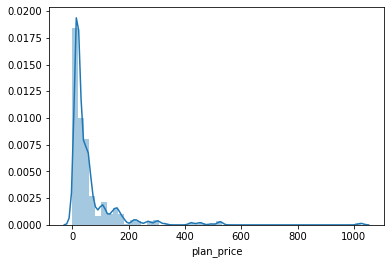

In [4]:
# plan_price distribution
sns.distplot(customer_data.plan_price);

**Number of unique values.** 

In [5]:
customer_data.nunique()
# 148 different customer acquisition sources

customer_id        891
converted            2
customer_cohort      3
gender               2
age                 88
added_referrals      7
added_friends        7
plan_price         248
source             148
country              3
dtype: int64

**How many null values?** 
Age seems to have a quite big propostion of null values, about 19%. 


In [6]:
customer_data.isnull().sum()

customer_id          0
converted            0
customer_cohort      0
gender               0
age                177
added_referrals      0
added_friends        0
plan_price           0
source               0
country              2
dtype: int64

**Numerical feature relationships**

The dataset is relatively small, 891 rows and ten variables. Let's have a look at the whole data set. Below we have scatterplot of all numerical features. Diagonal shows the histogram of each feature. 

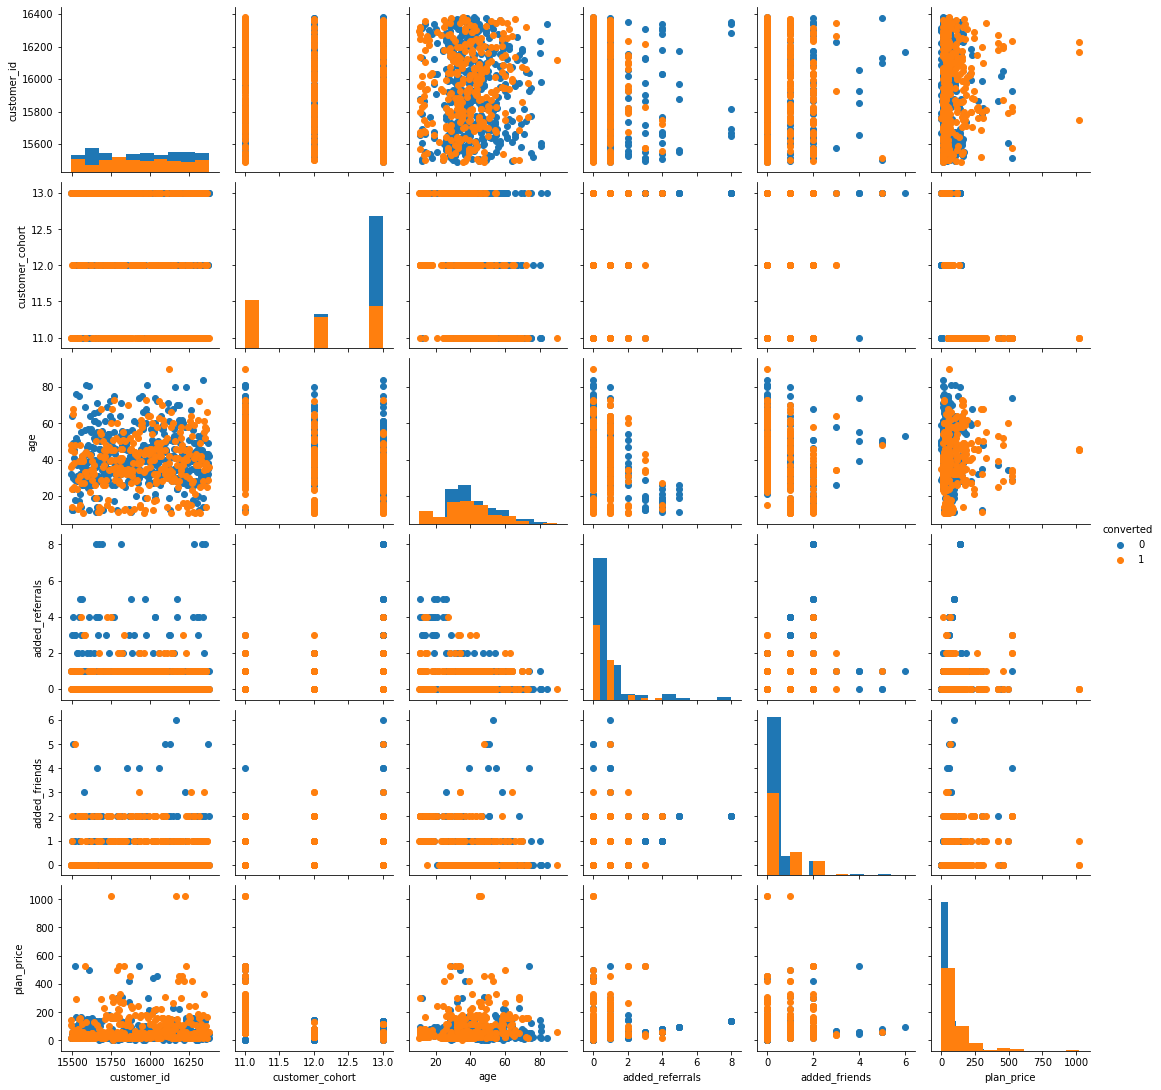

In [7]:
g = sns.PairGrid(customer_data, hue="converted")
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)
g.add_legend();


## Data transformations

Deal with missing values.

In [8]:
#replace missing age with median value 38. 
customer_data['age']=customer_data['age'].fillna(customer_data['age'].median())
# deal country nan
customer_data['country'] = customer_data['country'].fillna('unknown')
#check that there are no nulls left. 
customer_data.isnull().sum()

customer_id        0
converted          0
customer_cohort    0
gender             0
age                0
added_referrals    0
added_friends      0
plan_price         0
source             0
country            0
dtype: int64

Because of our transformation, we can see that there is a spike at 38. It looks like the age is bimodal, there are two age groups. One around 10 to 20 and other larger one from age 25 - 100.  

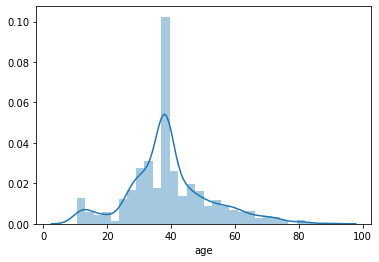

In [9]:
#distributions
sns.distplot(customer_data.age);

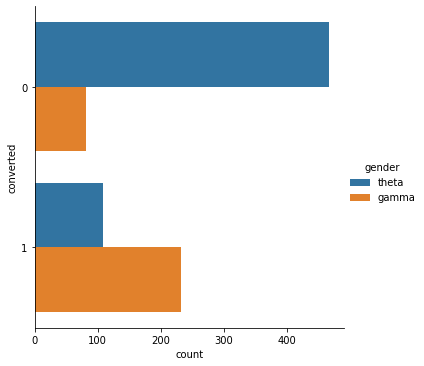

In [10]:
## thetas are well represented in the data. 
sns.catplot(y="converted", hue="gender", kind="count",
            data=customer_data
        ); # theta = 0, gamma = 1 

## Feature importance

Calculated scores for F-tests and Chi2. Used tree based estimators and correlation matrix. 
The methods based on F-test (f_classific) estimate the degree of linear dependency between two random variables.

### Transform categorical values to numeric one

For feature importance methods. Convert categorical values with numerical ones. 

In [11]:
customer_data.gender.unique()

array(['theta', 'gamma'], dtype=object)

In [12]:
# transofrm genre to numerical 
replace_genre_values = {'theta' : 0, 'gamma' : 1}                                                                                          
customer_data = customer_data.replace({'gender': replace_genre_values}) 
# transofrm country to numerical 
replace_country_values = {'USA' : 0, 'Canada': 1, 'Australia' :2, 'unknown' :3}                                                                                          
customer_data = customer_data.replace({'country': replace_country_values})
#transform source data with numerical
customer_data['source'] = customer_data.source.astype("category").cat.codes # replace sources with int values. 
customer_data.head(5)


,customer_id,converted,customer_cohort,gender,age,added_referrals,added_friends,plan_price,source,country
0,15490,0,13,0,32.0,1,0,14.5000,87,0
1,15491,1,11,1,48.0,1,0,142.5666,101,1
2,15492,1,13,1,36.0,0,0,15.8500,87,0
3,15493,1,11,1,45.0,1,0,106.2000,99,0
4,15494,0,13,0,45.0,0,0,16.1000,87,0


In [13]:
#remove customer id from data -> no predictive power
cust_features = customer_data.drop('customer_id', 1)
# store independent columns
X = cust_features.iloc[:,1:9] 
# store target column
Y = cust_features.iloc[:,0]

### F-scores 
Compute the ANOVA F-value for the provided sample. Tests if the means between two populations are significantly different.

The F-statistic is simply a ratio of two variances. Variances are a measure of dispersion, or how far the data are scattered from the mean. Larger values represent greater dispersion.

In [14]:
# feature extraction
test = SelectKBest(score_func=f_classif, k='all')
F_fit = test.fit(X, Y)
dfscores = pd.DataFrame(F_fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Columns','F_Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'F_Score'))  #print 10 best features

           Columns     F_Score
1           gender  372.405724
0  customer_cohort  115.031272
5       plan_price   63.030764
6           source   14.216245
7          country   12.558867
4    added_friends    5.963464
2              age    3.761528
3  added_referrals    1.110572


In [15]:
customer_data.isnull().sum()

customer_id        0
converted          0
customer_cohort    0
gender             0
age                0
added_referrals    0
added_friends      0
plan_price         0
source             0
country            0
dtype: int64

### Chi2

In [16]:
#try score_func=chi2, - > statistical tests for the strongest relationships  for the conversion
testChi2 = SelectKBest(score_func=chi2, k='all')
chi2_fit = testChi2.fit(X, Y)
dfscoreschi2 = pd.DataFrame(chi2_fit.scores_)
dfcolumnschi2 = pd.DataFrame(X.columns)
chi2featureScores = pd.concat([dfcolumnschi2,dfscoreschi2],axis=1)
chi2featureScores.columns = ['Columns','Chi2_Score']  #naming the dataframe columns
print(chi2featureScores.nlargest(10,'Chi2_Score'))  #print 10 best features

           Columns   Chi2_Score
5       plan_price  9036.638181
1           gender   170.348127
6           source    75.525713
2              age    16.149089
7          country    14.124257
4    added_friends    10.097499
0  customer_cohort     5.790754
3  added_referrals     2.581865


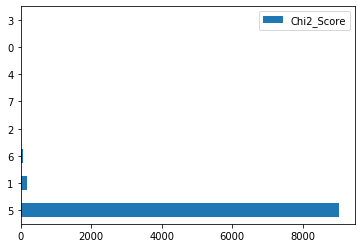

In [17]:
chi2featureScores.nlargest(10,'Chi2_Score').plot(kind='barh')
plt.show()#print 10 best features

### Tree based classifier


In [18]:
model = ExtraTreesClassifier() # default parameters 
model.fit(X,Y)
treeFeatureScores = pd.Series(model.feature_importances_, index=X.columns)
treeFeatureScores.nlargest(10)

gender             0.283394
age                0.218523
plan_price         0.207869
customer_cohort    0.093714
source             0.074175
added_referrals    0.046284
added_friends      0.043290
country            0.032751
dtype: float64

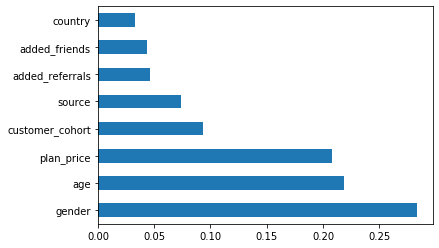

In [19]:
treeFeatureScores.nlargest(10).plot(kind='barh')

### Correlations

Text(0.5, 1, 'Correlations')

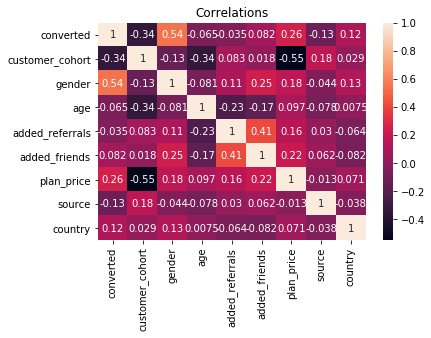

In [20]:
sns.heatmap(cust_features.corr(),annot=True)
plt.title('Correlations')

Text(0.5, 1, 'Correlations')

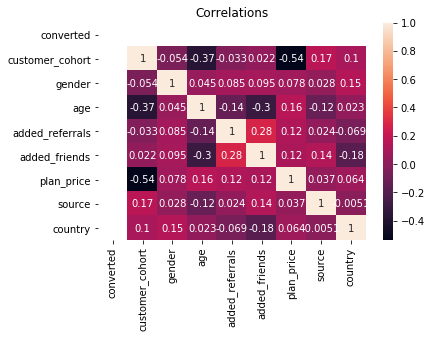

In [21]:
#Calculate correlations per converted customers. 
#This plot helps to determine is the feature having a positive or negative impact on conversion 

sns.heatmap(cust_features[cust_features['converted']== 1].corr(),annot=True)
plt.title('Correlations')